# Consistent Bayes: Examples from the Paper
---

Copyright 2018 Michael Pilosov

Based on work done by ... 

### Import Libraries
_tested with python 3.6 on 02/11/18_

In [1]:
# Mathematics and Plotting
from HelperFuns import * # pyplot wrapper functions useful for visualizations, numpy, scipy, etc.
# %matplotlib inline
# %matplotlib notebook
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = 8, 5
from cbayes import sample, solve, distributions
# Interactivity
from ipywidgets import *

# import numpy as np
from scipy.integrate import odeint
# import matplotlib.pyplot as plt
import progressbar


# Example Summary

---



---
## Define Functions

In [2]:
##### FIXED PARAMETERS #####

num_observations = 52 # how many observations are you able to make over the year?
assumed_population_size = 1E5 # your assumed population size (truth for the model)
infection_rate = 0.2 # (ppl/day) assumed infection rate
recovery_time = 10 # (1/days) assumed recovery rate. both of these shouldn't matter if we do a good job ID'ing them.
####

def SSE_generator(model, obs_data, sigma=1):   # this generates a sum of squared residuals.
    def QoI_fun(inputs): # that conforms to our desired model input
        predictions = model(inputs)
        assert predictions.shape[1] == len(obs_data)
        residuals = predictions - obs_data
        QoI = np.sum( (residuals/sigma)**2, axis=1 )
        return QoI
    return QoI_fun

# The SIR model differential equations.
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def SIR(beta=infection_rate, gamma = 1./recovery_time, I0=1./assumed_population_size, t=np.linspace(0,365,52),verbose=False):
    # I0 is number of initial infected individuals
    # R0 is number of initial  recovered/immune individuals
    # S0 is everyone else, the susceptible 
    # beta is contact rate (socialness of society) (ppl/day)
    # gamma is recovery rate (days^-1)
    R0 = 0 # WE ALSO ASSUME ZERO NATURAL IMMUNITY OR VACCINE
    S0 = 1. - R0 - I0
    try:
        assert(S0+I0+R0 == 1)
    except AssertionError:
        print("R0 must be nonnegative. you passed infeasible parameters")
        pass
    y0 = np.array([S0, I0, R0])     # Initial conditions vector
    if verbose:
        print("[b, g] = [%.2f, %.2f], [S0 I0 R0] = [%.2f, %1.2e, %1.2e]"%(beta, gamma, y0[0], y0[1], y0[2]), "| max time =", t[-1], "| h =", len(t))
    ret = odeint(deriv, y0, t, args=(beta, gamma))
    S, I, R = ret.T # Integrate the SIR equations over the time grid, t.
    return S, I, R


# This is for when we collect 2-D data
def epidemic_IR(lam, verbose=False):
    num_samples = lam.shape[0]
    days = 365
    h = num_observations
    t = np.linspace(0, days, h)
    I_out = np.empty(shape=(num_samples, h))
    R_out = np.empty(shape=(num_samples, h))
    bar = progressbar.ProgressBar()
    for n in bar(range(num_samples)):
        beta, gamma, S0 = lam[n,:]
        S, I, R = SIR(beta, gamma, S0, t, verbose=verbose)
        I_out[n,:] = I
        R_out[n,:] = R
    return np.array([I_out, R_out])


def epidemic_I(lam, verbose=False): # necessary wrapper functions for SSE_generator
    I_out, R_out = epidemic_IR(lam,verbose)
    return I_out

def epidemic_R(lam, verbose=False):
    I_out, R_out = epidemic_IR(lam,verbose)
    return R_out

[b, g] = [0.20, 0.10], [S0 I0 R0] = [1.00, 1.00e-05, 0.00e+00] | max time = 365.0 | h = 52


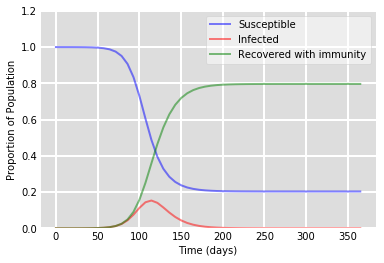

In [3]:
t = np.linspace(0, 365, num_observations)
S,I,R = SIR(t=t,verbose=True)
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Proportion of Population')

ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)

ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Get a sense of the variation 

A common parameter choice is $\beta$ = 0.2 and $\gamma$ = 0.1, let us see how much varation this leads to:

In [4]:
n = int(1E1)
beta = 0.2
gamma = 0.1
num_days = 365
lam = np.zeros((n,3))
lam[:,0] = beta
lam[:,1] = gamma
lam[:,2] = 1./np.linspace(1E3, 1E6, n)# I0
data = epidemic_IR(lam,verbose=False)

100% (10 of 10) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00


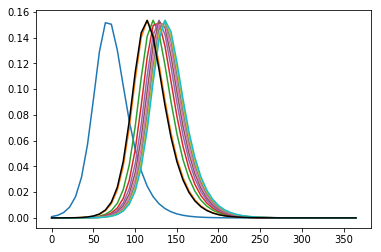

In [5]:
# Plotting the default IR results from the epidemic_IR function.
t = np.linspace(0,num_days,num_observations) # time vector
for i in range(n):
    plt.plot(t, data[0, i, :]) # I
#     plt.plot(t, data[1, i, :]) # R
#     plt.plot(t, 1 - data[0, i, :] - data[1, i, :])
plt.plot(t,I,c='k')


--- 

# Define Your Parameter-to-Observables Map


In [6]:
observables = 2 # are you observing I (num_obs = 1) or both I and R (num_obs = 2)
output_dim = 2 # are you assimilating the data into a 1D or 2D vector?
sd_R = 1
sd_I = 1

--- 

# Define Prior Measure $P_\Lambda$


In [7]:
input_dim = 3 # Specify input space dimension (n)
num_samples = int(1E4) # number of input samples (N)
s_set = sample.sample_set(size=(num_samples, input_dim))
min_population_size = 100 # that you are willing to consider.
max_population_size = 1E6 # that you are willing to consider.

s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0, 'scale': 1}, dim=0) # beta - rate of (ppl/day)
s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 0, 'scale': 1}, dim=1) # gamma - recovery rate (1/days)
s_set.set_dist('beta', kwds={'a': 1, 'b': 1, 'loc': 1./max_population_size, 'scale': 1./min_population_size - 1./max_population_size}, dim=2) # I_0 (1/population_size)
s_set.generate_samples()

lam = s_set.samples # create a pointer for ease of reference later with plotting.

### Visualize Prior 

In [8]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(None), 
                    N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
                    eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
                    view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
                    view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=2), IntSlider(value=2, continuous_update=False, description='view_dim_2', max=2), IntSlider(value=500, continuous_update=False, description='N', max=5000, min=100, step=100), Text(value='orange', continuous_update=False, description='color'), Checkbox(value=False, description='svd'), Output()), _dom_classes=('widget-interact',))

---
# Compute Data Space $O(\Lambda) = \mathcal{D}$ 

Format: `(n_dims, n_samples)`  

In [9]:
S_t, I_t, R_t = SIR() # t as a subscript stands for "truth"
obs_data_I = I_t + np.random.randn(int(num_observations))*sd_I
obs_data_R = R_t + np.random.randn(int(num_observations))*sd_R

if observables == 2:
    if output_dim == 1: # concatenate the Chi^2 data.
        def PtO_fun(inputs): # that conforms to our desired model input
            predictions = epidemic_IR(inputs)
            assert predictions.shape[2] == len(obs_data_I)
            residuals_I = predictions[0,:,:] - obs_data_I
            residuals_R = predictions[1,:,:] - obs_data_R
            
            QoI = np.sum( (residuals_R/sd_R)**2, axis=1 ) + np.sum( (residuals_I/sd_I)**2, axis=1 )
            return QoI
        
    else: # output_dim = 2, treat as dual-Chi^2
        def PtO_fun(inputs): # that conforms to our desired model input
            predictions = epidemic_IR(inputs)
            assert predictions.shape[2] == len(obs_data_I)
            residuals_I = predictions[0,:,:] - obs_data_I
            residuals_R = predictions[1,:,:] - obs_data_R
            
            QoI_R = np.sum((residuals_R/sd_R)**2, axis=1 ) 
            QoI_I = np.sum( (residuals_I/sd_I)**2, axis=1 )
            return np.array([QoI_I, QoI_R])
else: # one observable
    PtO_fun = SSE_generator(epidemic_I, obs_data_I, sd_I)

In [10]:
p_set = sample.map_samples_and_create_problem(s_set, PtO_fun)
D = p_set.output.samples

# This is how we handle trying to infer the dimension based on what the map put out.
# You can delete this once you are certain your model is correctly defined.
try:
    output_dim = D.shape[1] # if your function was coded correctly, you should have an (n, d) data space.
except IndexError:
    print(Warning("Warning: Your map might be returning the wrong dimensional data."))
    try:
       output_dim = D.shape[0] 
    except IndexError:
        print(Warning("Warning: Guessing it's 1-dimensional."))
        output_dim = 1
print('dimensions :  lambda = '+str(lam.shape)+'   D = '+str(D.shape) )

100% (10000 of 10000) |###################| Elapsed Time: 0:00:10 Time: 0:00:10


dimensions :  lambda = (10000, 3)   D = (10000, 2)


# Compute Push-Forward of the Prior $P_{O(\Lambda)}$
_ ... i.e. Characterize the Data Space_

In [11]:
# Interactive Marginal Visualization
p_set.compute_pushforward_dist()
pf_dist = p_set.pushforward_dist

In [12]:
# pf_dist.kde_object.set_bandwidth(1E-10)
# %matplotlib inline

In [13]:
widgets.interactive(pltdata, data = fixed(pf_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=10000, min = 100, max=10000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="brown", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=1), IntSlider(value=1, continuous_update=False, description='view_dim_2', max=1), IntSlider(value=10000, continuous_update=False, description='N', max=10000, min=100, step=100), Text(value='brown', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

# Define Observed Probability Measure $P_\mathcal{D}$

In [14]:
if observables == 1: # you get to observe I
    p_set.set_observed_dist('chi2', {'df':num_observations}, dim=0)
else: # you get to observe R as well
    if output_dim == 1:
        p_set.set_observed_dist('chi2', {'df':2*num_observations}, dim=0)
    else:
        p_set.set_observed_dist('chi2', {'df':num_observations}, dim=0)
        p_set.set_observed_dist('chi2', {'df':num_observations}, dim=1)

obs_dist = p_set.observed_dist # this is define a pointer for ease of reference.

widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=1), IntSlider(value=1, continuous_update=False, description='view_dim_2', max=1), IntSlider(value=500, continuous_update=False, description='N', max=5000, min=100, step=100), Text(value='wine', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

---

At this point we have performed the computations we need to. We have evaluated the input points through our map and performed a KDE on them. It would be useful at this point to save this object and/or its evaluation at every point in the data space for later re-use. Doing so here would be an appropriate place. 

--- 

# Accept/Reject Sampling of Posterior

Since we have already used the samples in our prior to compute the pushforward density, we can re-use these with an accept/reject algorithm to get a set of samples generated from the posterior according to the solution of the stochastic inverse problem as outlined in the Consistent Bayes formulation. 

In [15]:
p_set.set_ratio()
eta_r = p_set.ratio
solve.problem(p_set)

In [16]:
accept_inds = p_set.accept_inds
lam_accept = p_set.input.samples[accept_inds,:]
num_accept = len(accept_inds)
print('Number accepted: %d = %2.2f%%'%(num_accept, 100*np.float(num_accept)/num_samples))

Number accepted: 27 = 0.27%


## Visualize Posterior Density
### (Visualize Accept/Reject Samples)


In [17]:
widgets.interactive(pltdata, data = fixed(lam), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept+1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=widgets.Checkbox(value=False), color=widgets.Text(value="orange", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=input_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=input_dim-1, min=0, max=input_dim-1, step=1, continuous_update=False))

# You will visualize the accepted samples in a subset of size N of the input samples. 
# This is mostly for faster plotting, but also so you can see the progression of accepted sampling in the algorithm.


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=2), IntSlider(value=2, continuous_update=False, description='view_dim_2', max=2), IntSlider(value=13, continuous_update=False, description='N', max=28, min=2), Text(value='orange', continuous_update=False, description='color'), Checkbox(value=False, description='svd'), Output()), _dom_classes=('widget-interact',))

---
# Now what? 

Well, we can...

## _Visualize the Quality of our SIP Solution by Comparing it to the Observed_
_We compare the push-forward of the posterior using accepted samples against the observed density_  
_(SIP = Stochastic Inverse Problem)_
### Observed:

In [18]:
widgets.interactive(pltdata, data = fixed(obs_dist), inds = fixed(None), 
        N = widgets.IntSlider(value=500, min = 100, max=5000, step=100, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="wine", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))

interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=1), IntSlider(value=1, continuous_update=False, description='view_dim_2', max=1), IntSlider(value=500, continuous_update=False, description='N', max=5000, min=100, step=100), Text(value='wine', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

## Pushforward of Posterior:

In [19]:
widgets.interactive(pltdata, data = fixed(D), inds = fixed(accept_inds), 
        N = widgets.IntSlider(value=num_accept/2, min = 2, max=num_accept-1, step=1, continuous_update=False), 
        eta_r = fixed(None), space=fixed(0.05), svd=fixed(False), color=widgets.Text(value="eggplant", continuous_update=False),
        view_dim_1 = widgets.IntSlider(value=0, min=0, max=output_dim-1, step=1, continuous_update=False), 
        view_dim_2 = widgets.IntSlider(value=output_dim-1, min=0, max=output_dim-1, step=1, continuous_update=False))


interactive(children=(IntSlider(value=0, continuous_update=False, description='view_dim_1', max=1), IntSlider(value=1, continuous_update=False, description='view_dim_2', max=1), IntSlider(value=13, continuous_update=False, description='N', max=26, min=2), Text(value='eggplant', continuous_update=False, description='color'), Output()), _dom_classes=('widget-interact',))

## Verify our parametric test statistics.
Let's see if the pushforward of the posterior results in a sample mean and standard deviation that are close to the observed.

In [20]:
[np.mean(D[accept_inds,:]), np.std(D[accept_inds,:])]

[62.844841646961456, 4.5623401660501255]

In [21]:
[p_set.observed_dist.mean(), p_set.observed_dist.std()]

AttributeError: 'parametric_dist' object has no attribute 'mean'

Now go back to the [Sampling Section](#Sample-from-Prior) and change the distribution on the prior or choose another example problem.